In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  # Do other imports now...

import tensorflow as tf

# Need to specify the memory_limit for my local machine for some reason, but didn't seem to be required
# on AWS machine
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6400)])

# Check tensorflow version
print("Using Tensorflow %s" % (tf.__version__))
print("Using Keras %s\n" % (tf.keras.__version__))

# Check to see if graphics card is doing OK memory-wise
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using Tensorflow 2.1.0
Using Keras 2.2.4-tf

Wed Mar 25 00:00:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:08:00.0 Off |                  N/A |
| 40%   60C    P2   188W / 280W |  24093MiB / 24220MiB |     36%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 207...  Off  | 00000000:43:00.0  On |                  N/A |
| 41%   36C    P8     7W / 215W |    902MiB /  7974MiB |

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import h5py
import math
import glob
import time
import pandas as pd

#from tensorflow.keras import backend as K
#K.clear_session()
#tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [3]:
## Helper function if we need to recreate dataframes
## Avoid recreating them if the .csv files already exists

def create_dataframe(video_dir):
    pattern = os.path.join(video_dir, "*.hdf5")
    hdf5_files = glob.glob(pattern)
    entries = []

    for file in sorted(hdf5_files):

        # Try to open the file, if another process is writing to it
        # this should fail, which ensures we only read files that 
        # are complete
        try:
            with h5py.File(file, "r") as f:

                X = f["X"]
                category_name = X.attrs["category_name"]
                
                for idx in range(len(X)):
                    if X[str(idx)].shape[0] < 20:
                        continue
                    filename = f["idx_to_fn"][str(idx)][()]
                    entries.append([filename, idx, category_name, file])
                    
            print(".", end='')

        except:
            pass

    df = pd.DataFrame(entries, columns=["filename", "index", "category", "location"])
    return df



## Read training and validation sets into our dataframes

In [4]:
# Avoid recreating the dataframes, this is an expensive task as it 
# takes a while to read all hdf5 files to create the dataframes.
recreate_dataframes = False

if (recreate_dataframes):
    train_df = create_dataframe("videos/train/")
    validation_df = create_dataframe("./videos/validate")
    
    # Write the dataframes out to 
    train_df.to_csv('dataframes/train_df.csv', index=False)
    validate_df.to_csv('dataframes/validate_df.csv', index=False)
else:
    train_df = pd.read_csv("dataframes/train_df.csv")
    validation_df = pd.read_csv("dataframes/validate_df.csv")
    
train_sample_count = len(train_df.index)
validation_sample_count = len(validation_df.index)

In [5]:
train_df

,filename,index,category,location
0,1-Sv4f4woCI_000044_000054.mp4,0,abseiling,videos/train/abseiling.hdf5
1,7rGHBHnBB-g_000014_000024.mp4,1,abseiling,videos/train/abseiling.hdf5
2,vPxZC50Ajjw_000062_000072.mp4,2,abseiling,videos/train/abseiling.hdf5
3,CRhya73Txgo_000172_000182.mp4,3,abseiling,videos/train/abseiling.hdf5
4,VWnSwPoNsHI_000159_000169.mp4,4,abseiling,videos/train/abseiling.hdf5
...,...,...,...,...
349448,tStNkz8yEyY_000001_000011.mp4,843,zumba,videos/train/zumba.hdf5
349449,ZgCLIn5uXkw_000002_000012.mp4,844,zumba,videos/train/zumba.hdf5
349450,K6mSdaIHzls_000283_000293.mp4,845,zumba,videos/train/zumba.hdf5
349451,ARDulBjTaFI_000070_000080.mp4,846,zumba,videos/train/zumba.hdf5


In [6]:
validation_df

,filename,index,category,location
0,VHJGX13S_UY_000554_000564.mp4,0,abseiling,videos/validate/abseiling.hdf5
1,__NrybzYzUg_000415_000425.mp4,1,abseiling,videos/validate/abseiling.hdf5
2,Zv09PB3YQAs_000010_000020.mp4,2,abseiling,videos/validate/abseiling.hdf5
3,n6lUXDwL4Y0_000022_000032.mp4,3,abseiling,videos/validate/abseiling.hdf5
4,XaH22IFN81Y_000056_000066.mp4,4,abseiling,videos/validate/abseiling.hdf5
...,...,...,...,...
26620,r5CiCcQ6T_w_000068_000078.mp4,42,zumba,videos/validate/zumba.hdf5
26621,KSPA_DzZUQw_000009_000019.mp4,43,zumba,videos/validate/zumba.hdf5
26622,DABOOtlLIWE_000035_000045.mp4,44,zumba,videos/validate/zumba.hdf5
26623,J-0xHgijBy0_000000_000010.mp4,45,zumba,videos/validate/zumba.hdf5


videos/train/acting in play.hdf5


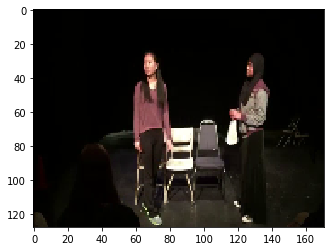

In [7]:
# Pick a training example and display one of it's frames to make sure these 
# are images
import matplotlib.pyplot as plt


filename = train_df.iloc[1000]["location"]
print(filename)
with h5py.File(filename, 'r') as fp:
    frames = fp["X"]["20"]
    
    plt.imshow(frames[100])
    

In [8]:
# Helper functions that will be called by our custom data generator to do some simple augmentation.
# The data generator will call augment_video with the index of the training/validation example, and 
# augment_video will return a mini_batch X, Y

import random
def choose_frames(frame_count, length):
    """ 
    Return a list of indices representing the chosen frames.
    
    frame_count : Total number of frames from the video
    length      : Number of frames in the returned list
    
    """    
    # Vary the frame_rate a little from 1 - 5
    frame_rate = min(frame_count // length, 5)
        
    frame_rate = random.randint(1, frame_rate)
    
    if (frame_count - (length * frame_rate)  < 0):
        print(frame_count)
        print(length)
        print(frame_rate)
        print(frame_count - (length * frame_count) )
    
    start = random.randint(0, frame_count - (length * frame_rate) )


    end = start + (length*frame_rate)
    #print("end: " + str(end))
    
    idxs = range(start, end, frame_rate)
    
    return idxs
    
def choose_vertical_positions(frame_height, height):
    start = random.randint(0, frame_height - height - 1)
    end = start + height
    return start, end

def choose_horizontal_positions(frame_width, width):
    start = random.randint(0, frame_width - width - 1)
    end = start + width
    return start, end
    
def augment_video(frames, frame_length, height, width):
    """
    Simple Augmentation which ensures that we return a frame of (frame_length, height, width, :)
    
    For temporal dimension, pick a sequence of frames of size 'frame_length'.
    For spatial dimensions, a random crop of of dimension (height, width) is performed on the frames to ensure it is the same
    shape as our neural networks input.
    
    """
    shape = frames.shape
    
    frame_count = shape[0]
    frame_height = shape[1]
    frame_width = shape[2]
    frame_channels = shape[3]
    
    frame_idxs = choose_frames(frame_count, frame_length)
    y1, y2 = choose_vertical_positions(frame_height, height)
    x1, x2 = choose_horizontal_positions(frame_width, width)
    
    
    return frames[frame_idxs, y1:y2, x1:x2, :]


In [9]:
# Our custom data generator which uses the training/validation dataframes to find the path to the
# hdf5 file that contains the video frames for the training/validation example.  The hdf5 file is 
# then read, and frames from the video of (length, height, width, 3) are returned.

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, class_mapping, length, height, width, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.count = len(df.index)
        self.df = df
        self.class_mapping = class_mapping
        self.n_classes = len(class_mapping)
        self.shuffle = shuffle
        
        # Number of frames in the temporal axis for the training data
        self.length = length
        self.height = height
        self.width = width
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.count / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.count)
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        # Initialization
        
        X = []
        Y = []
        # Generate data
        
        for index in indexes:
            
            # Get the appropriate hdf5 file
            hdf5_file = self.df.iloc[index]['location']
            file_index = self.df.iloc[index]['index']
                
            with h5py.File(hdf5_file, "r") as f:
                hdf5_X = f["X"]
                frames = hdf5_X[str(file_index)][()]
                
                frames = augment_video(frames, self.length, self.height, self.width) 
                frames = frames/255.
                
                category_name = self.df.iloc[index]['category']
                label = self.class_mapping[category_name]
            
                X.append(frames)
                Y.append(to_categorical(label, num_classes))            
                
        return np.array(X), np.array(Y) 

In [10]:
def get_class_mapping(categories):
    # classes should be sorted
    class_to_idx = dict()
    idx_to_class = dict()
    
    for i, category in enumerate(categories):
        class_to_idx[category] = i
        idx_to_class[i] = category
        
    return class_to_idx, idx_to_class

# Modify categories to a sorted list!! Iterating a set, which is unordered, will produce
# non-deterministic behavior when iterating categories giving us a different mapping for
# each session, which throws away our training efforts from previous sessions
categories = sorted(list(set(train_df.category)))

class_to_idx, idx_to_class = get_class_mapping(categories)
num_classes = len(class_to_idx)

In [11]:
num_classes

600

In [12]:
# Modified a version of 2-D ResNeXt-101 found from a github repo to a 3-D ResNext-101

"""
Clean and simple Keras implementation of network architectures described in:
    - (ResNet-50) [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf).
    - (ResNeXt-50 32x4d) [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf).
    
Python 3.
"""


#
# image dimensions
#
frames = 16
img_height = 112
img_width = 112
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization(dtype="float32")(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv3D(nb_channels, kernel_size=(3, 3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv3D(_d, kernel_size=(3, 3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv3D(nb_channels_in, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv3D(nb_channels_out, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization(dtype="float32")(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv3D(nb_channels_out, kernel_size=(1, 1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization(dtype="float32")(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv3D(64, kernel_size=(7, 7, 7), strides=(1, 2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2, 2) if i == 0 else (1, 1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(23):
        strides = (2, 2, 2) if i == 0 else (1, 1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2, 2) if i == 0 else (1, 1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

    return x




In [13]:
batch_size = 12
directory = "models/3d-cnn/ResNeXt-101/SGD/checkpoints/"

validation_generator = DataGenerator(validation_df, class_to_idx, length=16, height=112, width=112, batch_size=batch_size, shuffle=True)


In [ ]:
import glob
import math
import time
checkpoints = sorted(glob.glob(directory + '/epoch*'))


df = pd.read_csv(directory + "/checkpoints.csv")

min_loss = df["val_loss"].min() if len(df.index) > 0 else math.inf


for checkpoint in checkpoints:

    print("processing ", checkpoint)
    start = time.time()
    model = load_model(checkpoint)
    loss, acc = model.evaluate_generator(validation_generator, validation_sample_count//batch_size, workers=8, use_multiprocessing=True)

    with open(directory + "/checkpoints.csv", "a") as fp:
        cp_name = os.path.basename(checkpoint)
        fp.write(f"{cp_name},{acc},{loss}\n")

    print(f"checkpoint: {cp_name}, acc: {acc:.5f}, loss: {loss:.5f}")
    end = time.time()
    print("Elapsed time: ", (end - start)/60.)
    #if loss <= min_loss:
    os.rename(checkpoint, f"{directory}/cp_" + cp_name)
    min_loss = loss
    #else:
    # Not better than previous chehuman activity recognition with deep learning historyckpoints, remove
    #    os.remove(checkpoint)




#score = model.evaluate_generator(validation_generator, validation_sample_count//batch_size, workers=12, use_multiprocessing=True)

processing  models/3d-cnn/ResNeXt-101/SGD/checkpoints/epoch_19.h5
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


In [13]:
def C3D(num_classes):
    
    model = Sequential()
    model.add(layers.Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv1a",
                       input_shape=(16, 112,112,3)))
    model.add(layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), name = "Pool1"))
    model.add(layers.Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv2a"))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), name="Pool2"))
    model.add(layers.Conv3D(256, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv3a"))
    model.add(layers.Conv3D(256, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv3b"))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), name="Pool3"))
    model.add(layers.Conv3D(512, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv4a"))
    model.add(layers.Conv3D(512, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv4b"))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), name="Pool4"))
    model.add(layers.Conv3D(512, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv5a"))
    model.add(layers.Conv3D(512, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name="Conv5b"))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), name="Pool5"))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation="relu", name="fc6"))
    model.add(layers.Dense(4096, activation="relu", name="fc7"))
    model.add(layers.Dense(num_classes, activation="softmax", dtype="float32"))
    return model


In [14]:
batch_size = 12
directory = "models/3d-cnn/ResNeXt-101/SGD/checkpoints/"

train_generator = DataGenerator(train_df, class_to_idx, length=16, height=112, width=112, batch_size=batch_size, shuffle=True)
validation_generator = DataGenerator(validation_df, class_to_idx, length=16, height=112, width=112, batch_size=batch_size, shuffle=True)


In [17]:
restore_model = True
model_path = directory + "/epoch_3.h5"

if (restore_model):
    model = load_model(model_path)
else:
    image_tensor = layers.Input(shape=(frames, img_height, img_width, img_channels))
    network_output = residual_network(image_tensor)
    model = Model(inputs=[image_tensor], outputs=[network_output])
    
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 112, 112 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 16, 56, 56, 6 65920       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 56, 56, 6 256         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 56, 56, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv3d_298 (Conv3D)             (None, 2, 7, 7, 16)  6928        lambda_277[0][0]                 
__________________________________________________________________________________________________
conv3d_299 (Conv3D)             (None, 2, 7, 7, 16)  6928        lambda_278[0][0]                 
__________________________________________________________________________________________________
conv3d_300 (Conv3D)             (None, 2, 7, 7, 16)  6928        lambda_279[0][0]                 
__________________________________________________________________________________________________
conv3d_301 (Conv3D)             (None, 2, 7, 7, 16)  6928        lambda_280[0][0]                 
__________________________________________________________________________________________________
conv3d_302 (Conv3D)             (None, 2, 7, 7, 16)  6928        lambda_281[0][0]                 
__________________________________________________________________________________________________
conv3d_303

__________________________________________________________________________________________________
conv3d_615 (Conv3D)             (None, 2, 7, 7, 1024 525312      leaky_re_lu_53[0][0]             
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 2, 7, 7, 1024 4096        conv3d_615[0][0]                 
__________________________________________________________________________________________________
add_17 (Add)                    (None, 2, 7, 7, 1024 0           leaky_re_lu_51[0][0]             
                                                                 batch_normalization_57[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_54 (LeakyReLU)      (None, 2, 7, 7, 1024 0           add_17[0][0]                     
__________________________________________________________________________________________________
conv3d_616

__________________________________________________________________________________________________
lambda_900 (Lambda)             (None, 2, 7, 7, 16)  0           leaky_re_lu_85[0][0]             
__________________________________________________________________________________________________
lambda_901 (Lambda)             (None, 2, 7, 7, 16)  0           leaky_re_lu_85[0][0]             
__________________________________________________________________________________________________
lambda_902 (Lambda)             (None, 2, 7, 7, 16)  0           leaky_re_lu_85[0][0]             
__________________________________________________________________________________________________
lambda_903 (Lambda)             (None, 2, 7, 7, 16)  0           leaky_re_lu_85[0][0]             
__________________________________________________________________________________________________
lambda_904 (Lambda)             (None, 2, 7, 7, 16)  0           leaky_re_lu_85[0][0]             
__________

In [18]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger("training_log.csv", separator=',', append=True)

def checkpoint_sanity_check(filepath):
    directory = os.path.dirname(filepath)
    
    if not os.path.isdir(directory):
        raise Exception('Checkpoint directory does not exist!')
        


class HistoryLogger(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(HistoryLogger, self).__init__()
        self.epoch = 0
        self.loss = []
        self.acc = []
        self.epoch_loss = []
        self.epoch_acc = []
        self.epoch_val_loss = []
        self.epoch_val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch + 1
        try:
            self.epoch_loss.append(logs.get('loss'))
            self.epoch_acc.append(logs.get('acc'))
            self.epoch_val_loss.append(logs.get('val_loss'))
            self.epoch_val_acc.append(logs.get('val_acc'))
        except:
            print("Failed log data on epoch end")
       

    
class EarlyStop(tf.keras.callbacks.Callback):
    """Callback that terminates training when flag=1 is encountered.
    """
    def on_batch_end(self, batch, logs=None):
        try:
            os.remove("./keras.end_batch")
            self.model.stop_training = True
        except:
            pass
            
    def on_epoch_end(self, batch, logs=None):
        try:
            os.remove("./keras.end_epoch")
            self.model.stop_training = True
        except:
            pass
        
class SaveWeights(tf.keras.callbacks.Callback):
    def __init__(self, model, directory):
        self.dir = directory
        self.model = model
        self.start_time = 0
        
        if not os.path.isdir(directory):
            raise Exception('Checkpoint directory does not exist!')
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        
        loss = logs.get('loss')
        filepath = os.path.join(self.dir, f"epoch_{epoch+1}.h5")
        print(f" ( {(time.time() - self.start_time)/60} min)")
        self.model.save(filepath)    
        

logger = HistoryLogger()
early_stop = EarlyStop()

checkpoint = SaveWeights(model, directory + "/checkpoints/")


#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
#                                  save_best_only=False, save_weights_only=True, mode='min')

# call back for tensorboard
#logdir = "models/3d-cnn/logs"
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#callbacks = [csv_logger, logger, checkpoint, early_stop]

callbacks = [csv_logger, checkpoint, logger, early_stop]

Exception: Checkpoint directory does not exist!

In [17]:
prev_epoch = 0
epochs=4

from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr=0.1, decay=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['acc'])

#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics = ['acc'])


In [ ]:
history = model.fit_generator(generator=train_generator, steps_per_epoch = train_sample_count //batch_size,
                   #validation_data=validation_generator, validation_steps=validation_sample_count // batch_size,
                   callbacks=callbacks, epochs=epochs, initial_epoch = prev_epoch,
                   use_multiprocessing=True, workers=12)



Train for 4368 steps
Epoch 1/4
4368/4368 [==============================] - 10606s 2s/step - loss: 6.1434 - acc: 0.0105
Epoch 2/4
2296/4368 [==============>...............] - ETA: 1:22:36 - loss: 5.7962 - acc: 0.0230

In [ ]:
%debug

> <ipython-input-14-d744fd3ef0ed>(21)<module>()
     19     with open("checkpoints/checkpoints.csv", "a") as fp:
     20         cp_name = os.path.basename(checkpoint)
---> 21         fp.write(f"{cp_name},{acc},{val_loss}\n")
     22 
     23     print(f"checkpoint: {cp_name}, loss: {acc:02}, acc: {loss:02}")

ipdb> loss
4.315247325293989
ipdb> acc
0.18975903


In [ ]:
train_df

In [17]:
score

[4.266843920012555, 0.16965361]

In [ ]:
output = model.evaluate_generator(validation_generator, validation_sample_count//batch_size, workers=16, use_multiprocessing=True)

In [19]:
model.save("models/3d-cnn/ResNeXt_101-600_cat-epoch_9.h5")

In [ ]:
opt = tf.keras.optimzers.Adam()
opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
model.compile(loss=loss, optimizer=opt)

In [ ]:

loss = loss_fn()
opt = tf.AdamOptimizer(learning_rate=...)

# Choose a loss scale manager which decides how to pick the right loss scale
# throughout the training process.
loss_scale_manger = tf.contrib.mixed_precision.FixedLossScaleManager(5000)

# Wraps the original optimizer in a LossScaleOptimizer.
loss_scale_optimizer = LossScaleOptimizer(opt, loss_scale_manager)

# Call minimize() on the loss scale optimizer.
train_op = loss_scale_optimizer.minimize(loss)